In [343]:
#import all packages 
import pandas as pd
import warnings
import statsmodels.api as sm
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('../data/kc_house_data.csv')

In [344]:
data.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,1.000000,-0.225209,-0.347210,-0.148370,0.409993,0.326377,0.070777
yr_renovated,-0.012010,0.129599,0.018495,0.051050,0.055660,0.004513,0.003535,0.022137,-0.225209,1.000000,0.069846,0.032145,-0.072156,-0.000247,0.003852


In [345]:
# drop columns that have no desire to our stakeholder 
clean_null = data.drop(columns=['id','date','long','yr_built','condition','view', 'waterfront',], axis=1)


In [827]:
clean_null.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
count,1.216700e+04,12167.000000,12167.000000,12167.000000,1.216700e+04,12167.000000,12167.000000,12167.000000,9960.000000,12167.000000,12167.000000,12167.000000,12167.000000,12167.000000,12167.000000,12167.000000
mean,4.313894e+05,2.762226,1.825881,1649.790745,1.382301e+04,1.411317,1456.069450,193.721295,74.071486,98082.947070,47.559083,1741.498233,12053.375935,1456.069450,314.329345,7.299006
std,1.868897e+05,0.451778,0.639466,590.251510,3.839053e+04,0.557503,541.480171,323.271575,377.135042,53.616259,0.141986,509.438725,26960.999028,541.480171,136.337730,0.923875
min,1.049500e+05,1.000000,1.000000,610.000000,5.720000e+02,1.000000,480.000000,0.000000,0.000000,98001.000000,47.155900,399.000000,651.000000,480.000000,87.647059,4.000000
25%,2.895000e+05,3.000000,1.000000,1230.000000,4.515000e+03,1.000000,1080.000000,0.000000,0.000000,98034.000000,47.463650,1380.000000,4745.500000,1080.000000,210.201175,7.000000
50%,4.000000e+05,3.000000,1.750000,1560.000000,7.210000e+03,1.000000,1330.000000,0.000000,0.000000,98075.000000,47.568900,1640.000000,7313.000000,1330.000000,285.937500,7.000000
75%,5.350000e+05,3.000000,2.500000,1960.000000,9.880000e+03,2.000000,1700.000000,350.000000,0.000000,98119.000000,47.682750,2020.000000,9600.000000,1700.000000,390.000000,8.000000
max,1.190000e+06,3.000000,3.750000,4930.000000,1.164794e+06,3.500000,4610.000000,1990.000000,2015.000000,98199.000000,47.777600,4950.000000,560617.000000,4610.000000,1336.206897,12.000000


In [828]:
# locating outliers in bedroom 
clean_null = clean_null.loc[clean_null['bedrooms'] < 8]
clean_null = clean_null.loc[clean_null['bathrooms'] < 6]
clean_null = clean_null.loc[clean_null['sqft_living'] < 6000 ]
clean_null = clean_null.loc[clean_null['price'] < 1500000 ]
clean_null = clean_null.loc[clean_null['bedrooms'] > .99]
clean_null = clean_null.loc[clean_null['bathrooms'] > .99]
clean_null = clean_null.loc[clean_null['sqft_living'] > 600 ]
clean_null = clean_null.loc[clean_null['price'] > 100000 ]
clean_null = clean_null.loc[clean_null['sqft_lot'] < 100000 ]
clean_null = clean_null.loc[clean_null['floors'] < 2.1 ]
#clean_null = clean_null.loc[clean_null['sqft_lot'] > 100000 ]
#clean_null = clean_null.loc[clean_null['sqft_lot'] > 100000 ]
#clean_null = clean_null.loc[clean_null['sqft_lot'] > 100000 ]


In [829]:
clean_null = clean_null.loc[clean_null['sqft_basement'] != '?' ] 

In [830]:
clean_null['sqft_basement'] = clean_null['sqft_basement'].astype(float)

In [831]:
clean_null['true_sqft'] = clean_null['sqft_living']  - clean_null['sqft_basement']


In [832]:
# creating a new feature of price per sqft
clean_null['price_per_sqft'] = clean_null['price']  / clean_null['true_sqft']


In [833]:
test = [i[0:2].strip() for i in clean_null['grade']]


In [834]:
clean_null['grade_ordinal'] = [int(i[0:2].strip()) for i in clean_null['grade']]

In [835]:
zip_home_size = clean_null.loc[clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164])]



In [836]:
curated_zip = np.array([98052,98102,98103,98105,98109,98119,98121,98134,98164])

In [837]:

# TODO add these OHE'd columns to main data by assigning <dfname>['zipcodes_ohe']
#
# take out the isin function for all zipcodes, if that makes the OLS work. could also narrow down to curated after the OHE on all zipcodes
zips = clean_null.loc[clean_null['zipcode'].isin(curated_zip)].dropna() 
ohe = OneHotEncoder(sparse=False, drop=[98109]) # the zip code with the highest prices in Seattle. could do 98052, near the Microsoft campus as well
ohe.fit(zips['zipcode'].to_numpy().reshape(-1, 1))
zips_encoded = ohe.transform(zips['zipcode'].to_numpy().reshape(-1, 1))

zipcodes_ohe = pd.DataFrame(zips_encoded, columns=ohe.get_feature_names(), index=zips.index)

In [838]:
zip_home_size.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'zipcode',
       'lat', 'sqft_living15', 'sqft_lot15', 'true_sqft', 'price_per_sqft',
       'grade_ordinal'],
      dtype='object')

In [839]:
zip_home_size.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
price,1.000000,0.290326,0.303135,0.621709,0.054129,0.253058,0.496814,0.287479,0.081808,0.169196,-0.266562,0.473071,0.033847,0.496814,0.353813,0.519381
bedrooms,0.290326,1.000000,0.418551,0.534198,0.244677,0.208461,0.470212,0.179547,0.004291,-0.317818,0.049643,0.276734,0.225638,0.470212,-0.292439,0.298844
bathrooms,0.303135,0.418551,1.000000,0.586242,0.118398,0.510891,0.479536,0.253850,0.041591,-0.270815,-0.055044,0.303995,0.116872,0.479536,-0.225616,0.567291
sqft_living,0.621709,0.534198,0.586242,1.000000,0.371321,0.337481,0.816056,0.436014,0.004268,-0.331867,0.076727,0.614230,0.352383,0.816056,-0.285384,0.605876
sqft_lot,0.054129,0.244677,0.118398,0.371321,1.000000,-0.172974,0.382632,0.037938,-0.049296,-0.562171,0.361743,0.425305,0.876477,0.382632,-0.325054,0.172367
floors,0.253058,0.208461,0.510891,0.337481,-0.172974,1.000000,0.498979,-0.200975,0.039213,-0.029141,-0.129004,0.191015,-0.158640,0.498979,-0.308409,0.510482
sqft_above,0.496814,0.470212,0.479536,0.816056,0.382632,0.498979,1.000000,-0.164329,-0.013972,-0.443639,0.137091,0.612294,0.368401,1.000000,-0.583012,0.617424
sqft_basement,0.287479,0.179547,0.253850,0.436014,0.037938,-0.200975,-0.164329,1.000000,0.029654,0.124387,-0.082512,0.094904,0.027777,-0.164329,0.420732,0.072659
yr_renovated,0.081808,0.004291,0.041591,0.004268,-0.049296,0.039213,-0.013972,0.029654,1.000000,0.084663,-0.035674,-0.065093,-0.041798,-0.013972,0.086001,0.000880
zipcode,0.169196,-0.317818,-0.270815,-0.331867,-0.562171,-0.029141,-0.443639,0.124387,0.084663,1.000000,-0.384480,-0.404230,-0.550917,-0.443639,0.577857,-0.255097


In [886]:
zip_new_columns = zip_home_size.drop(columns=['zipcode','grade','price_per_sqft','sqft_lot15','sqft_lot'], axis=1)
#zip_new_columns.reset_index(inplace=True, drop=True)


In [887]:
# concat two dataframes 
zip_ohe_columns = pd.concat([zip_new_columns , zipcodes_ohe], axis=1)
zip_ohe_columns

,price,bedrooms,bathrooms,sqft_living,floors,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal,x0_98052,x0_98102,x0_98103,x0_98105,x0_98119
26,937000.0,3,1.75,2450,2.0,1750,700.0,NaN,47.6386,1760,1750.0,8,NaN,NaN,NaN,NaN,NaN
43,685000.0,3,1.00,1570,2.0,1570,0.0,0.0,47.6413,1580,1570.0,7,0.0,0.0,0.0,0.0,1.0
85,940000.0,3,1.50,2140,2.0,1900,240.0,0.0,47.6337,2020,1900.0,9,0.0,0.0,0.0,0.0,1.0
100,850830.0,3,2.50,2070,1.5,1270,800.0,0.0,47.6415,2200,1270.0,9,0.0,1.0,0.0,0.0,0.0
111,570000.0,3,1.75,1260,1.0,700,560.0,0.0,47.6823,1380,700.0,6,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21385,438000.0,2,1.00,980,2.0,980,0.0,0.0,47.6381,1190,980.0,8,0.0,0.0,0.0,0.0,1.0
21460,433000.0,3,2.50,1270,2.0,1060,210.0,0.0,47.6568,1260,1060.0,8,0.0,0.0,0.0,1.0,0.0
21541,530000.0,3,2.50,1410,2.0,1140,270.0,NaN,47.6515,1720,1140.0,8,NaN,NaN,NaN,NaN,NaN
21563,645000.0,3,3.25,1730,2.0,1320,410.0,0.0,47.6374,1710,1320.0,9,0.0,0.0,0.0,0.0,1.0


In [888]:
zip_ohe_columns = zip_ohe_columns.dropna()


In [889]:
zip_ohe_columns = zip_ohe_columns.drop(columns=['x0_98102',
       'x0_98103', 'x0_98105', 'x0_98119'], axis=1)
#zip_new_columns.reset_index(inplace=True, drop=True)

In [890]:
zip_ohe_columns.corr()

,price,bedrooms,bathrooms,sqft_living,floors,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15,true_sqft,grade_ordinal,x0_98052
price,1.000000,0.291987,0.313596,0.626035,0.246308,0.504824,0.284633,0.081808,-0.271487,0.493635,0.504824,0.532463,-0.118679
bedrooms,0.291987,1.000000,0.410997,0.524323,0.204756,0.466333,0.169115,0.004291,0.064786,0.291781,0.466333,0.313564,0.331386
bathrooms,0.313596,0.410997,1.000000,0.594362,0.511068,0.479787,0.269432,0.041591,-0.051615,0.323869,0.479787,0.562996,0.303864
sqft_living,0.626035,0.524323,0.594362,1.000000,0.345913,0.823122,0.428022,0.004268,0.080913,0.639116,0.823122,0.620395,0.353094
floors,0.246308,0.204756,0.511068,0.345913,1.000000,0.506878,-0.205497,0.039213,-0.129117,0.215444,0.506878,0.503144,0.054659
sqft_above,0.504824,0.466333,0.479787,0.823122,0.506878,1.000000,-0.160904,-0.013972,0.128162,0.644235,1.000000,0.638473,0.464218
sqft_basement,0.284633,0.169115,0.269432,0.428022,-0.205497,-0.160904,1.000000,0.029654,-0.063343,0.085495,-0.160904,0.062127,-0.125122
yr_renovated,0.081808,0.004291,0.041591,0.004268,0.039213,-0.013972,0.029654,1.000000,-0.035674,-0.065093,-0.013972,0.000880,-0.072117
lat,-0.271487,0.064786,-0.051615,0.080913,-0.129117,0.128162,-0.063343,-0.035674,1.000000,0.010096,0.128162,-0.093559,0.322157
sqft_living15,0.493635,0.291781,0.323869,0.639116,0.215444,0.644235,0.085495,-0.065093,0.010096,1.000000,0.644235,0.561401,0.442544


In [891]:
zip_ohe_columns.columns


Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15', 'true_sqft',
       'grade_ordinal', 'x0_98052'],
      dtype='object')

In [892]:

y = zip_ohe_columns['price']
x = zip_ohe_columns['sqft_living']
X_c = sm.add_constant(x)


simple_model = sm.OLS(y, X_c)


simple_model_results = simple_model.fit()
print(simple_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     437.0
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           2.83e-75
Time:                        00:10:29   Log-Likelihood:                -8973.0
No. Observations:                 680   AIC:                         1.795e+04
Df Residuals:                     678   BIC:                         1.796e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.736e+05   1.58e+04     17.304      

In [893]:
#reviewing coef and p value significants 
y = zip_ohe_columns['price']
X = zip_ohe_columns.drop(['price'], axis=1)





y = y.dropna()
X = X.dropna()

# len(y), len(X)
ols_kch = sm.OLS(y, sm.add_constant(X)).fit()
ols_kch.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     130.7
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          4.61e-150
Time:                        00:10:30   Log-Likelihood:                -8773.8
No. Observations:                 680   AIC:                         1.757e+04
Df Residuals:                     669   BIC:                         1.762e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.891e+07   8.19e+06      7.196      0.000    4.28e+07     7.5e+07
bedrooms       2.285e+04   9131.998      2.503      0.013    4923.557    4.08e+04
bathrooms     -1.486e+04   8646.420     -1.718      0.086   -3.18e+04    2118.658
sqft_living      87.6635      7.512     11.670      0.000      72.913     102.414
floors        -5.268e+04   1.22e+04     -4.327      0.000   -7.66e+04   -2.88e+04
sqft_above       46.4297      5.420      8.566      0.000      35.788      57.072
sqft_basement    41.2331      8.809      4.681      0.000      23.936      58.530
yr_renovated     25.4200      8.936      2.845      0.005       7.873      42.967
lat           -1.238e+06   1.72e+05     -7.218      0.000   -1.58e+06   -9.01e+05
sqft_living15    76.1724     11.997      6.350      0.000      52.617      99.728
true_sqft        46.4292      5.420      8.566      0.000      35.787      57.071
grade_ordinal  5.023e+04   6533.751      7.688      0.000    3.74e+04    6.31e+04
x0_98052      -1.635e+05   1.09e+04    -14.964      0.000   -1.85e+05   -1.42e+05
==============================================================================
Omnibus:                       56.886   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.907
Skew:                          -0.390   Prob(JB):                     9.41e-37
Kurtosis:                       5.291   Cond. No.                     9.68e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.7e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [894]:
#identifying the lots we recommend the stakeholder purchase and build new multifamily homes. 

zip_lot_size = clean_null.loc[(clean_null['zipcode'].isin([98052,98102,98103,98105,98109,98119,98121,98134,98164]))
                              & (clean_null['sqft_lot'] >= 40000)]

zip_lot_size

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,sqft_living15,sqft_lot15,true_sqft,price_per_sqft,grade_ordinal
3671,620000.0,3,2.25,2190,45738,1.0,8 Good,2190,0.0,0.0,98052,47.7108,2970,4496,2190.0,283.105023,8
6578,550000.0,3,2.25,1980,40887,1.0,8 Good,1980,0.0,NaN,98052,47.6478,2460,35700,1980.0,277.777778,8
11512,849000.0,3,3.00,2960,42159,2.0,10 Very Good,2960,0.0,0.0,98052,47.7183,2640,25209,2960.0,286.824324,10
17323,476800.0,3,1.75,1900,43700,1.5,6 Low Average,1900,0.0,0.0,98052,47.7265,2070,43995,1900.0,250.947368,6


In [895]:
#Linearity
X = zip_ohe_columns.drop(['price'], axis=1)
ss = StandardScaler().fit(X)

X_scaled = ss.transform(X)

In [896]:
X_c = sm.add_constant(X_scaled)
y = zip_ohe_columns['price']

In [897]:
model = sm.OLS(endog=y, exog=X_c).fit()

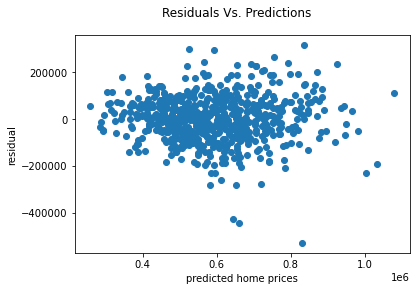

In [898]:
model_preds = model.predict(X_c)
resids = y - model_preds

fig, ax = plt.subplots()

ax.scatter(model_preds, resids)
ax.set_xlabel('predicted home prices')
ax.set_ylabel('residual')
plt.suptitle('Residuals Vs. Predictions');

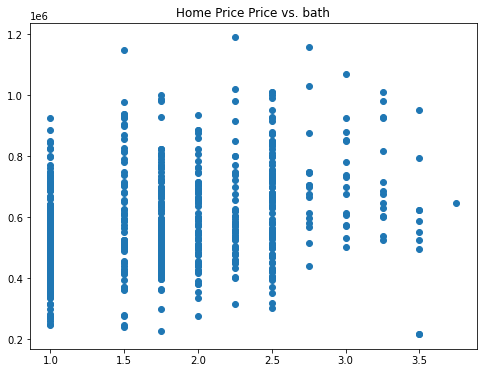

In [899]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))


ax.scatter(X['bathrooms'], y)
ax.set_title('Home Price Price vs. bath');

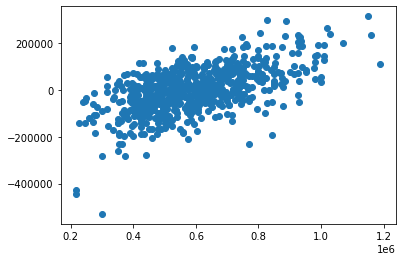

In [900]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

In [901]:
dw = sm.stats.stattools.durbin_watson

In [902]:
dw(resids)

1.9248082248820968

In [903]:
model.summary().tables[2]

Omnibus:,56.886,Durbin-Watson:,1.925
Prob(Omnibus):,0.000,Jarque-Bera (JB):,165.907
Skew:,-0.390,Prob(JB):,9.41e-37
Kurtosis:,5.291,Cond. No.,7.72e+15


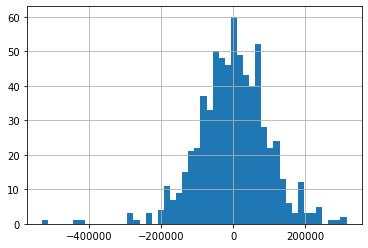

In [904]:
resids.hist(bins=50);

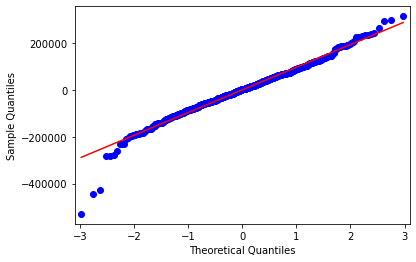

In [907]:
sm.qqplot(resids, line='r');

In [917]:
zip_ohe_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680 entries, 43 to 21567
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          680 non-null    float64
 1   bedrooms       680 non-null    int64  
 2   bathrooms      680 non-null    float64
 3   sqft_living    680 non-null    int64  
 4   floors         680 non-null    float64
 5   sqft_above     680 non-null    int64  
 6   sqft_basement  680 non-null    float64
 7   yr_renovated   680 non-null    float64
 8   lat            680 non-null    float64
 9   sqft_living15  680 non-null    int64  
 10  true_sqft      680 non-null    float64
 11  grade_ordinal  680 non-null    int64  
 12  x0_98052       680 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 74.4 KB


In [929]:
zip_ohe_columns['grade_ordinal'].unique()

array([ 7,  9,  6,  8, 10, 11,  5], dtype=int64)

ValueError: x and y must be the same size

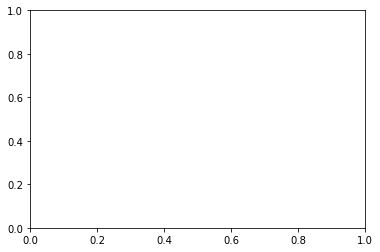

In [934]:
fig, ax = plt.subplots()

ax.scatter(y=zip_ohe_columns['price'], x=zip_ohe_columns.drop(['price'], axis=1));

In [910]:
model.summary().tables[2]

Omnibus:,56.886,Durbin-Watson:,1.925
Prob(Omnibus):,0.000,Jarque-Bera (JB):,165.907
Skew:,-0.390,Prob(JB):,9.41e-37
Kurtosis:,5.291,Cond. No.,7.72e+15


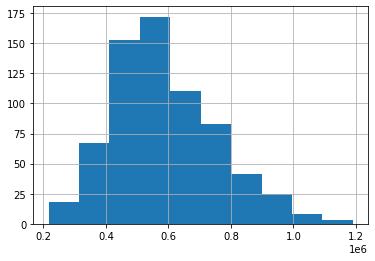

In [911]:
y.hist();

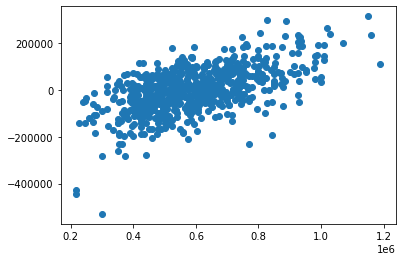

In [912]:
fig, ax = plt.subplots()

ax.scatter(y, resids);

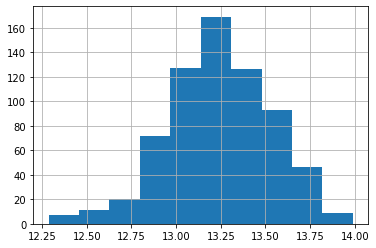

In [913]:
y_log = np.log(y)
y_log.hist();

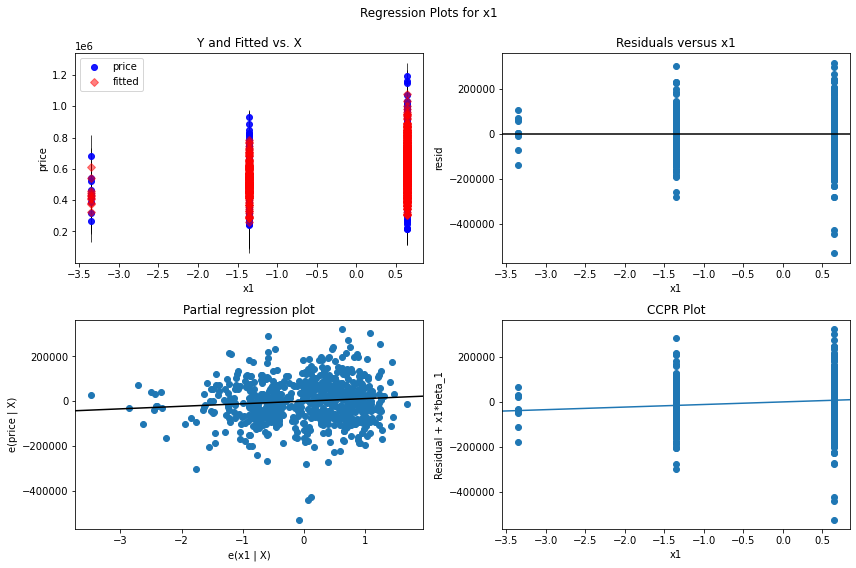

In [915]:
# 'x1' is 
sm.graphics.plot_regress_exog(model, 'x1', fig=plt.figure(figsize=(12, 8)));